# S11 WESAD XGBoost

    Female Participant
    Age: 26
    Height (cm): 171
    Weight (kg): 54

# Load Tools

In [2]:
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score 
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.utils import class_weight
import xgboost as xgb
from xgboost import plot_importance, XGBClassifier

In [5]:
sns.set(style="darkgrid")

In [6]:
# https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed#:~:text=Colors%3A%20Use%20this%20code%3A%20%3C,space%2C%20then%20type%20the%20text.
# https://www.w3schools.com/charsets/ref_utf_geometric.asp# import pydot

In [7]:
import autoreload
%load_ext watermark
%load_ext autoreload
%autoreload 2
%watermark -a 'WForsythe' -d -t -v -p   numpy,pandas,cv2,xgboost,sklearn,seaborn,matplotlib,yellowbrick

WForsythe 2020-08-02 16:23:13 

CPython 3.7.6
IPython 7.11.1

numpy 1.18.1
pandas 1.0.3
cv2 4.2.0
xgboost 1.0.2
sklearn 0.22.1
seaborn 0.9.0
matplotlib 3.2.2
yellowbrick 1.1


# Load and Process File

## Load File

In [8]:
%%time
data = 'D:/WESAD/'
s11_file = pd.read_pickle(data + 'S11/S11.pkl')
s11_file

Wall time: 10.2 s


{'signal': {'chest': {'ACC': array([[ 0.76740003,  0.42260003,  1.76620007],
          [ 0.73259997,  0.28779995,  1.72340012],
          [ 0.68939996,  0.11459994,  1.55500007],
          ...,
          [ 0.88139999,  0.05499995, -0.31900001],
          [ 0.87660003,  0.0546    , -0.32560003],
          [ 0.8714    ,  0.05540001, -0.32840002]]),
   'ECG': array([[ 0.02009583],
          [ 0.03684998],
          [ 0.0536499 ],
          ...,
          [-0.02677917],
          [-0.00682068],
          [ 0.01643372]]),
   'EMG': array([[-0.01387024],
          [-0.00201416],
          [-0.00759888],
          ...,
          [-0.04550171],
          [-0.04197693],
          [-0.02082825]]),
   'EDA': array([[6.60743713],
          [6.60324097],
          [6.60552979],
          ...,
          [6.37817383],
          [6.37702942],
          [6.38008118]]),
   'Temp': array([[33.520264],
          [33.494537],
          [33.50815 ],
          ...,
          [35.014282],
          [35.01892 

**there are 3 columns for both chest and wrist ACC and one column each for the other features**

## Process

### Seperate chest features  from wrist  features 

In [9]:
cax = s11_file['signal']['chest']['ACC'][0:,0]
cay = s11_file['signal']['chest']['ACC'][0:,1]
caz = s11_file['signal']['chest']['ACC'][0:,2]
cecg = s11_file['signal']['chest']['ECG'][:,0]
cemg = s11_file['signal']['chest']['EMG'][:,0]
ceda = s11_file['signal']['chest']['EDA'][:,0]
ctemp = s11_file['signal']['chest']['Temp'][:,0]
cresp = s11_file['signal']['chest']['Resp'][:,0]
label = s11_file['label']

In [10]:
label

array([0, 0, 0, ..., 0, 0, 0])

### Change dictionary object to a numpy array and array to a dataframe

In [11]:
# Python | Numpy ndarray.T
# https://www.geeksforgeeks.org/python-numpy-ndarray-t/
# Numpy Array Cookbook: Generating and Manipulating Arrays in Python
# https://towardsdatascience.com/numpy-array-cookbook-generating-and-manipulating-arrays-in-python-2195c3988b09

In [12]:
chest = [cax, cay, caz, cecg, cemg, 
         ceda, ctemp, cresp, label] 
ch_array = np.array(chest) 
ch_array = ch_array.T # transpose 
Columns = ['cax', 'cay', 'caz','cecg', 'cemg', 
          'ceda','ctemp', 'cresp', 'label' ]
ch_df = pd.DataFrame(ch_array, columns = Columns) 
ch_df

,cax,cay,caz,cecg,cemg,ceda,ctemp,cresp,label
0,0.7674,0.4226,1.7662,0.020096,-0.013870,6.607437,33.520264,2.120972,0.0
1,0.7326,0.2878,1.7234,0.036850,-0.002014,6.603241,33.494537,2.113342,0.0
2,0.6894,0.1146,1.5550,0.053650,-0.007599,6.605530,33.508148,2.122498,0.0
3,0.6646,-0.0626,1.3322,0.052780,-0.026505,6.611252,33.491516,2.125549,0.0
4,0.6590,-0.2322,1.0834,0.035751,-0.040421,6.609726,33.524780,2.131653,0.0
...,...,...,...,...,...,...,...,...,...
3663095,0.8854,0.0582,-0.3068,-0.027145,-0.045914,6.463242,35.029724,-0.650024,0.0
3663096,0.8830,0.0570,-0.3114,-0.032822,-0.047928,6.377792,34.989563,-0.669861,0.0
3663097,0.8814,0.0550,-0.3190,-0.026779,-0.045502,6.378174,35.014282,-0.639343,0.0
3663098,0.8766,0.0546,-0.3256,-0.006821,-0.041977,6.377029,35.018921,-0.648499,0.0


#### Check Statistics

In [13]:
ch_df.describe().T

,count,mean,std,min,25%,50%,75%,max
cax,3663100.0,0.883402,0.025900,0.297800,0.868000,0.883400,0.898000,2.037600
cay,3663100.0,0.012753,0.053536,-0.826200,-0.012200,0.009400,0.042400,0.499400
caz,3663100.0,-0.221811,0.110087,-1.547000,-0.288200,-0.240600,-0.182600,2.610800
cecg,3663100.0,0.001054,0.298879,-0.878952,-0.112839,-0.042206,0.036346,1.499954
cemg,3663100.0,-0.003610,0.013179,-0.359894,-0.010437,-0.003479,0.003159,0.335724
ceda,3663100.0,6.504319,0.421310,5.626297,6.250000,6.392288,6.624985,8.166885
ctemp,3663100.0,34.688962,0.328780,33.438599,34.549591,34.689331,34.967987,35.238495
cresp,3663100.0,0.050518,4.815635,-36.196899,-2.073669,-0.076294,2.253723,30.084229
label,3663100.0,1.475253,1.638622,0.000000,0.000000,1.000000,3.000000,7.000000


#### Check Type

In [14]:
ch_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3663100 entries, 0 to 3663099
Data columns (total 9 columns):
 #   Column  Dtype  
---  ------  -----  
 0   cax     float64
 1   cay     float64
 2   caz     float64
 3   cecg    float64
 4   cemg    float64
 5   ceda    float64
 6   ctemp   float64
 7   cresp   float64
 8   label   float64
dtypes: float64(9)
memory usage: 251.5 MB


In [15]:
ch_df['label'].value_counts()

0.0    1443400
1.0     826000
4.0     553701
2.0     476000
3.0     257600
6.0      36399
7.0      35000
5.0      35000
Name: label, dtype: int64

### Concatenate classes 0, 1, 2, 3, and 4
    Classes 5, 6 and 7 correspond to timed periods in which the participant answered questionnaires, 
    therefore, only classes 0, 1, 2, 3, and 4 will be used 
    Additionally, the significant imbalance has been eliminated

In [16]:
loc0 = ch_df.loc[ch_df['label'] == 0]
loc1 = ch_df.loc[ch_df['label'] == 1]
loc2 = ch_df.loc[ch_df['label'] == 2]
loc3 = ch_df.loc[ch_df['label'] == 3]
loc4 = ch_df.loc[ch_df['label'] == 4]

In [17]:
ch_loc = pd.concat([loc0, loc1, loc2, loc3, loc4])
ch_loc

,cax,cay,caz,cecg,cemg,ceda,ctemp,cresp,label
0,0.7674,0.4226,1.7662,0.020096,-0.013870,6.607437,33.520264,2.120972,0.0
1,0.7326,0.2878,1.7234,0.036850,-0.002014,6.603241,33.494537,2.113342,0.0
2,0.6894,0.1146,1.5550,0.053650,-0.007599,6.605530,33.508148,2.122498,0.0
3,0.6646,-0.0626,1.3322,0.052780,-0.026505,6.611252,33.491516,2.125549,0.0
4,0.6590,-0.2322,1.0834,0.035751,-0.040421,6.609726,33.524780,2.131653,0.0
...,...,...,...,...,...,...,...,...,...
3561332,0.8858,0.0022,-0.2758,0.077454,0.000595,6.375504,35.069885,-7.658386,4.0
3561333,0.8854,0.0036,-0.2738,0.080063,-0.005173,6.364059,35.060608,-7.655334,4.0
3561334,0.8842,0.0030,-0.2698,0.081436,0.007553,6.369400,35.065277,-7.658386,4.0
3561335,0.8850,0.0054,-0.2718,0.082626,0.002151,6.370926,35.051361,-7.667542,4.0


#### Check Statistics

In [18]:
ch_loc.describe().T

,count,mean,std,min,25%,50%,75%,max
cax,3556701.0,0.883466,0.026205,0.297800,0.867600,0.883600,0.898400,2.037600
cay,3556701.0,0.013238,0.054229,-0.826200,-0.012400,0.010400,0.043800,0.499400
caz,3556701.0,-0.220440,0.111337,-1.547000,-0.288600,-0.239000,-0.180600,2.610800
cecg,3556701.0,0.001062,0.298621,-0.878952,-0.113113,-0.042252,0.036484,1.499954
cemg,3556701.0,-0.003607,0.013215,-0.359894,-0.010391,-0.003479,0.003159,0.335724
ceda,3556701.0,6.500956,0.419819,5.626297,6.251526,6.394196,6.617737,8.166885
ctemp,3556701.0,34.686744,0.331836,33.438599,34.546509,34.692352,34.967987,35.238495
cresp,3556701.0,0.047712,4.859344,-36.196899,-2.066040,-0.065613,2.256775,30.084229
label,3556701.0,1.339894,1.454284,0.000000,0.000000,1.000000,2.000000,4.000000


#### Plot all classes vs. classes 0,1,2,3,4 

3663100 3556701
Number of Rows Removed: 106399


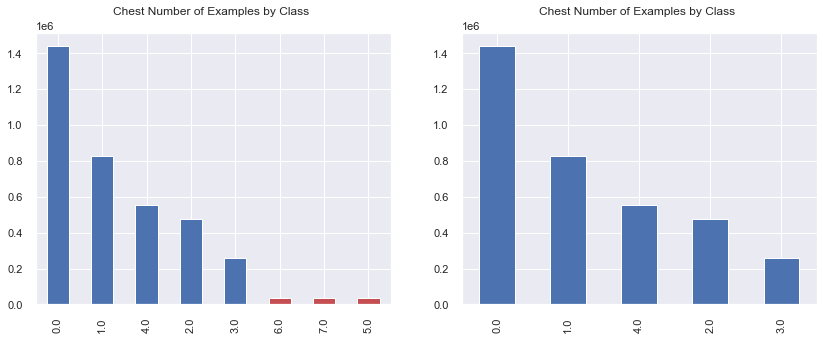

In [19]:
plt.figure(figsize = (14,5))
plt.subplot(1, 2, 1)
ch_df['label'].value_counts().plot(kind='bar', 
                                     title='Chest Number of Examples by Class \n',
                                     color=['b','b','b','b','b','r','r','r'])
plt.subplot(1, 2, 2)
ch_loc['label'].value_counts().plot(kind='bar', 
                                     title='Chest Number of Examples by Class \n')
print((ch_df['label'].value_counts().sum()), ch_loc['label'].value_counts().sum())
print('Number of Rows Removed:', (ch_df['label'].value_counts().sum()) - 
      ch_loc['label'].value_counts().sum());

**XGBoost for Multi-class Classification** <br>
https://towardsdatascience.com/xgboost-for-multi-class-classification-799d96bcd368

In [2]:
# Multiclass ROC AUC Score original script sourced from 
'''
Author: Plog, E
Title: AUC ROC Curve Scoring Function for Multi-class Classification
Date: 2018
Code version: n.a.
Availability: https://medium.com/@plog397/auc-roc-curve-scoring-function-for-multi-class-classification-9822871a6659
'''

'\nAuthor: Plog, E\nTitle: AUC ROC Curve Scoring Function for Multi-class Classification\nDate: 2018\nCode version: n.a.\nAvailability: https://medium.com/@plog397/auc-roc-curve-scoring-function-for-multi-class-classification-9822871a6659\n'

# Model Runs: XGBoost Classifier

**XGBoost for Multi-class Classification** <br>
https://towardsdatascience.com/xgboost-for-multi-class-classification-799d96bcd368

## Model allChest: All chest features

### Train Test

In [30]:
y = ch_loc.label
x = ch_loc.drop('label',axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print(x_train.shape)
print(y_test.shape)
evalSet = [(x_train, y_train), (x_test, y_test)]

(2845360, 8)
(711341,)


### Check Train Correlations

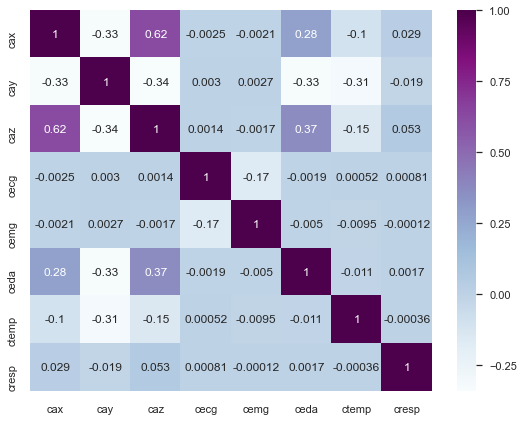

In [31]:
plt.figure(figsize=(9,7))
sns.heatmap(x_train.corr(), annot=True, cmap=plt.cm.BuPu);

There is one mildly strong correlation - between cax and caz - where the x-axis is forward/back and the z-axis is up/down.<br>
This makes sense considering that movement from standing to sitting or from sitting to standing would likely involve x-axis motion 

### Model Fit and f1 and Balanced Accuracy Scores

In [64]:
%%time
allChest = xgb.XGBClassifier(objective = 'multi:softmax',
                              tree_method = 'gpu_hist',
                              learning_rate = 0.1,
                              n_estimators = 300, 
                              max_depth = 10,
                              #deterministic_histogram = 'false',
                              gradient_based = 0.1,
                              num_early_stopping_rounds = 20,
                              gamma = 3,
                              #seed = 24,
                              verbosity = 2) 

model_allChest = allChest.fit(x_train,y_train, 
                              eval_metric=['merror'], # % of wrong cases
                              eval_set = evalSet) 

[0]	validation_0-merror:0.04256	validation_1-merror:0.04294
[1]	validation_0-merror:0.04044	validation_1-merror:0.04083
[2]	validation_0-merror:0.03922	validation_1-merror:0.03945
[3]	validation_0-merror:0.03873	validation_1-merror:0.03904
[4]	validation_0-merror:0.03880	validation_1-merror:0.03923
[5]	validation_0-merror:0.03730	validation_1-merror:0.03768
[6]	validation_0-merror:0.03695	validation_1-merror:0.03728
[7]	validation_0-merror:0.03637	validation_1-merror:0.03673
[8]	validation_0-merror:0.03606	validation_1-merror:0.03647
[9]	validation_0-merror:0.03574	validation_1-merror:0.03621
[10]	validation_0-merror:0.03499	validation_1-merror:0.03552
[11]	validation_0-merror:0.03461	validation_1-merror:0.03504
[12]	validation_0-merror:0.03447	validation_1-merror:0.03488
[13]	validation_0-merror:0.03383	validation_1-merror:0.03427
[14]	validation_0-merror:0.03354	validation_1-merror:0.03399
[15]	validation_0-merror:0.03327	validation_1-merror:0.03375
[16]	validation_0-merror:0.03306	v

[134]	validation_0-merror:0.01687	validation_1-merror:0.01844
[135]	validation_0-merror:0.01683	validation_1-merror:0.01840
[136]	validation_0-merror:0.01682	validation_1-merror:0.01839
[137]	validation_0-merror:0.01682	validation_1-merror:0.01839
[138]	validation_0-merror:0.01679	validation_1-merror:0.01838
[139]	validation_0-merror:0.01679	validation_1-merror:0.01838
[140]	validation_0-merror:0.01678	validation_1-merror:0.01837
[141]	validation_0-merror:0.01675	validation_1-merror:0.01832
[142]	validation_0-merror:0.01668	validation_1-merror:0.01823
[143]	validation_0-merror:0.01665	validation_1-merror:0.01821
[144]	validation_0-merror:0.01662	validation_1-merror:0.01819
[145]	validation_0-merror:0.01657	validation_1-merror:0.01817
[146]	validation_0-merror:0.01657	validation_1-merror:0.01817
[147]	validation_0-merror:0.01656	validation_1-merror:0.01814
[148]	validation_0-merror:0.01655	validation_1-merror:0.01814
[149]	validation_0-merror:0.01654	validation_1-merror:0.01813
[150]	va

### Balanced Accuracy and Classification Report

In [75]:
allChest_pred = allChest.predict(x_test)
allChest_report = (classification_report(y_test,
                                         allChest_pred,
                                         labels=np.unique(allChest_pred),
                                         digits=4))

print('----------------------------------------')
print('Balanced Accuracy: {0:.4f}'.format(balanced_accuracy_score(y_test, allChest_pred)))
print('----------------------------------------')
print('------------ S11 All Chest Classification Report------------')
print(allChest_report)

----------------------------------------
Balanced Accuracy: 0.9842
----------------------------------------
------------ S11 All Chest Classification Report------------
              precision    recall  f1-score   support

         0.0     0.9855    0.9719    0.9787    288395
         1.0     0.9955    0.9967    0.9961    165447
         2.0     0.9936    0.9958    0.9947     95455
         3.0     0.9726    0.9803    0.9764     51471
         4.0     0.9491    0.9762    0.9624    110573

    accuracy                         0.9822    711341
   macro avg     0.9792    0.9842    0.9817    711341
weighted avg     0.9823    0.9822    0.9822    711341



In [28]:
allChest_pred = allChest.predict(x_test)
allChest_report = (classification_report(y_test,
                                         allChest_pred,
                                         labels=np.unique(allChest_pred),
                                         digits=4))

print('----------------------------------------')
print('Balanced Accuracy: {0:.4f}'.format(balanced_accuracy_score(y_test, allChest_pred)))
print('----------------------------------------')
print('------------ S11 All Chest Classification Report------------')
print(allChest_report)

----------------------------------------
Balanced Accuracy: 0.9798
----------------------------------------
------------ S11 All Chest Classification Report------------
              precision    recall  f1-score   support

         0.0     0.9820    0.9660    0.9739    288879
         1.0     0.9946    0.9969    0.9957    164984
         2.0     0.9899    0.9941    0.9920     95259
         3.0     0.9644    0.9711    0.9678     51757
         4.0     0.9404    0.9708    0.9554    110462

    accuracy                         0.9780    711341
   macro avg     0.9743    0.9798    0.9770    711341
weighted avg     0.9782    0.9780    0.9781    711341



### Multiclass error Plot

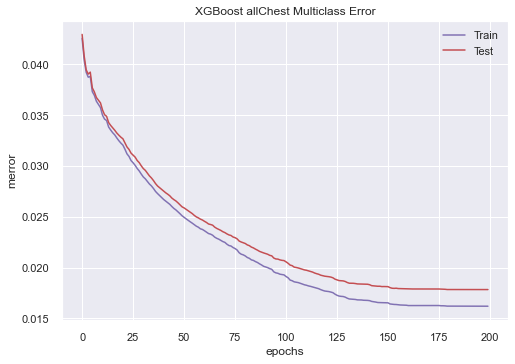

In [65]:
# multi-class classification error plot 
# https://stackoverflow.com/questions/51900874/how-to-plot-xgboost-evaluation-metrics

results = allChest.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label = 'Train', c = 'm')
ax.plot(x_axis, results['validation_1']['merror'], label = 'Test', c = 'r')
plt.legend(loc = 'upper right')
plt.ylabel('merror')
plt.xlabel('epochs')
plt.title('XGBoost allChest Multiclass Error');

    Model stops improving at 184 epochs.
    Afterwards, test and train remain relatively parallel indicating that over-fitting is not present

### Confusion Matrix

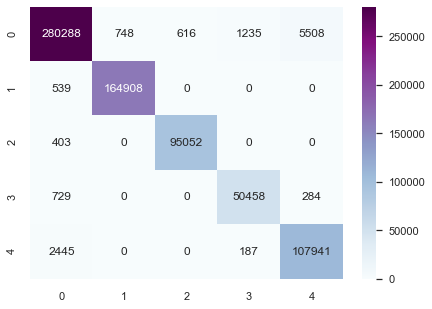

In [67]:
cm = confusion_matrix(y_test, allChest_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.BuPu );

## Model ACC TEMP EDA

### Test Train Split

In [20]:
less_Emg_Ecg = ch_loc[['ceda', 'ctemp', 'cax', 'cay', 'caz', 'label']]
y = less_Emg_Ecg.label
x = less_Emg_Ecg.drop('label',axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print(x_train.shape)
print(y_test.shape)

(2845360, 5)
(711341,)


### Model Fit, classification report, and Balanced Accuracy 

In [21]:
%%time
accEdaTemp = XGBClassifier(objective = 'multi:softmax',
                           tree_method = 'gpu_hist',
                           learning_rate = 0.1,
                           gradient_based = 0.1,
                           num_early_stopping_rounds = 20,
                           n_estimators = 300,
                           gamma = 3,
                           verbosity = 2) 

model_accEdaTemp = accEdaTemp.fit(x_train, y_train)
accEdaTemp_pred = accEdaTemp.predict(x_test)
accEdaTemp_report = (classification_report(y_test, 
                                         accEdaTemp_pred, 
                                         labels = np.unique(accEdaTemp_pred),
                                         digits = 4))

print('Balanced Accuracy:', balanced_accuracy_score(y_test, accEdaTemp_pred))
print('---------------------------------------')
print('------------ S11 ACC EDA TEMP Classification Report------------')
print(accEdaTemp_report)

Balanced Accuracy: 0.9709339778002073
---------------------------------------
------------ S11 ACC EDA TEMP Classification Report------------
              precision    recall  f1-score   support

         0.0     0.9741    0.9520    0.9629    288141
         1.0     0.9926    0.9957    0.9942    165413
         2.0     0.9867    0.9916    0.9891     95062
         3.0     0.9552    0.9576    0.9564     51757
         4.0     0.9131    0.9578    0.9349    110968

    accuracy                         0.9688    711341
   macro avg     0.9643    0.9709    0.9675    711341
weighted avg     0.9692    0.9688    0.9688    711341

Wall time: 1min 14s


### Confusion matrix

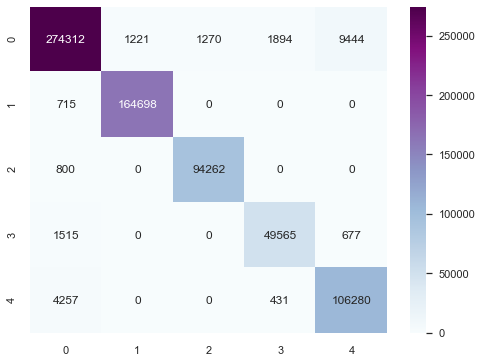

In [22]:
cm = confusion_matrix(y_test, accEdaTemp_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.BuPu );